In [5]:
# EOmaps example 5: Add overlays and indicators
%matplotlib widget
from eomaps import Maps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [6]:
# create some data
lon, lat = np.meshgrid(np.linspace(-20, 40, 100), np.linspace(30, 60, 100))
data = pd.DataFrame(
    dict(
        lon=lon.flat,
        lat=lat.flat,
        param=(((lon - lon.mean()) ** 2 - (lat - lat.mean()) ** 2)).flat,
    )
)
data_OK = data[data.param >= 0]
data_OK.var = np.sqrt(data_OK.param)
data_mask = data[data.param < 0]

D:\python_modules\eomaps\eomaps\eomaps.py:461: UserWarning: EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') when using the 'ipympl' backend to avoid recursions during callbacks!
  "EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') "
D:\python_modules\eomaps\eomaps\_shapes.py:591: UserWarning: EOmaps: rectangles with 'mesh=True' only supports n=1
  "EOmaps: rectangles with 'mesh=True' only supports n=1"


EOmaps: Parameter was set to: 'param'
EOmaps: estimating radius...
EOmaps: The estimated radius is: 0.1515
EOmaps: Parameter was set to: 'param'
EOmaps: estimating radius...
EOmaps: The estimated radius is: 0.1515
EOmaps: Parameter was set to: 'param'
FETCHTED A BACKGROUND


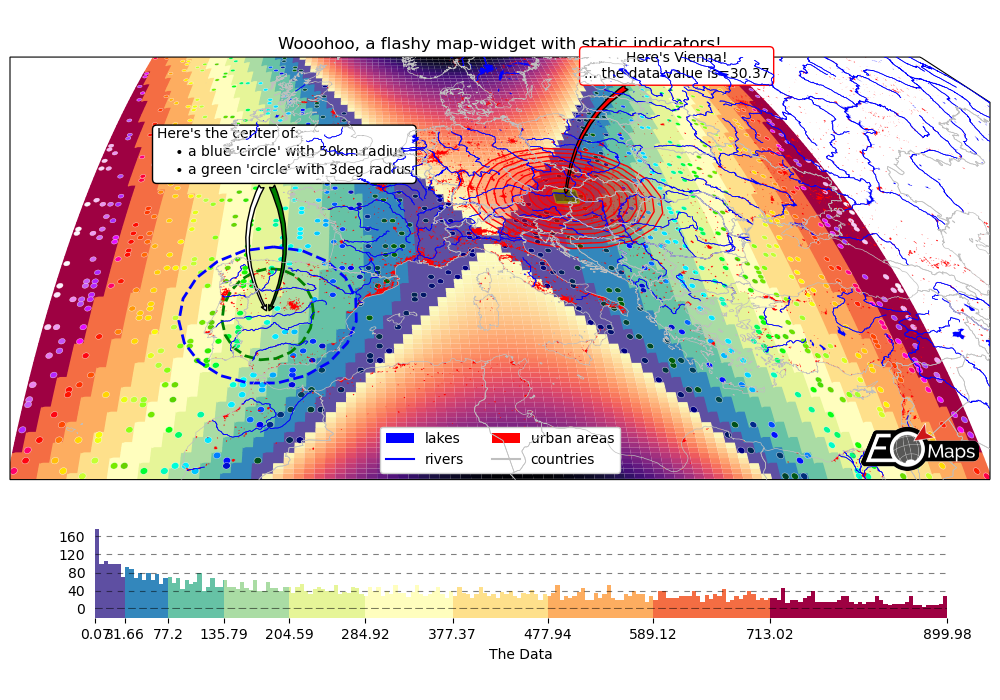

In [7]:
# --------- initialize a Maps object and plot a basic map
m = Maps(Maps.CRS.Orthographic(), figsize=(10, 6))
m.ax.set_title("Wooohoo, a flashy map-widget with static indicators!")
m.set_data(data=data_OK, xcoord="lon", ycoord="lat", in_crs=4326)
m.set_plot_specs(
    histbins=200,
    cmap="Spectral_r",
)
m.set_shape.rectangles(mesh=True)
m.set_classify_specs(scheme="Quantiles", k=10)
# double the estimated radius in x-direction to make the plot dense
m.shape.radius = (m.shape.radius[0] * 2, m.shape.radius[1])

m.plot_map()
m.figure.f.set_figheight(7)

# ... add a basic "annotate" callback
cid = m.cb.click.attach.annotate(bbox=dict(alpha=0.75), color="w")

# --------- add another layer of data to indicate the values in the masked area
#           (copy all defined specs but the classification)
m2 = m.new_layer(copy_classify_specs=False)
m2.data_specs.data = data_mask
m2.set_shape.rectangles(mesh=False)
# double the estimated radius in x-direction to make the plot dense
m2.shape.radius = (m2.shape.radius[0] * 2, m2.shape.radius[1])

m2.plot_specs.cmap = "magma"
m2.plot_map()
# --------- add another layer with data that is dynamically updated if we click on the masked area
m3 = m.new_layer(copy_classify_specs=False)
m3.data_specs.data = data_OK.sample(1000)
m3.set_shape.ellipses(radius=25000, radius_crs=3857)
m3.set_plot_specs(cmap="gist_ncar")
# plot the map and assign a "dynamic_layer_idx" to allow dynamic updates of the collection

m3.plot_map(edgecolor="w", linewidth=0.25, layer=10, dynamic=True)

# --------- define a callback that will change the position and data-values of the additional layer
#           NOTE: this is not possible for the shapes:  "shade_points" and "shade_raster" !
def callback(self, **kwargs):
    selection = np.random.randint(0, len(m3.data), 1000)
    m3.figure.coll.set_array(data_OK.param.iloc[selection])


# attach the callback to the second Maps object such that it triggers when we click on the masked-area
m2.cb.click.attach(callback)

# --------- add some basic overlays from NaturalEarth

f0 = m.add_feature.physical_10m.lakes(ec="none", fc="b", zorder=100)
f1 = m.add_feature.physical_10m.rivers_lake_centerlines(
    ec="b", fc="none", lw=0.5, zorder=100
)
f2 = m.add_feature.cultural_10m.admin_0_countries(
    ec=".75", fc="none", lw=0.5, zorder=100
)
f3 = m.add_feature.cultural_10m.urban_areas(ec="none", fc="r")

# add a customized legend
m.figure.ax.legend(
    [
        Patch(fc="b"),
        plt.Line2D([], [], c="b"),
        Patch(fc="r"),
        plt.Line2D([], [], c=".75"),
    ],
    ["lakes", "rivers", "urban areas", "countries"],
    ncol=2,
    loc="lower center",
    facecolor="w",
    framealpha=1,
)

# --------- add some fancy (static) indicators for selected pixels
mark_id = 6060
for buffer in np.linspace(1, 5, 10):
    m.add_marker(
        ID=mark_id,
        shape="ellipses",
        radius="pixel",
        fc=[1, 0, 0, 0.1],
        ec="r",
        buffer=buffer * 5,
    )
m.add_marker(
    ID=mark_id, shape="rectangles", radius="pixel", fc="g", ec="y", buffer=3, alpha=0.5
)
m.add_marker(
    ID=mark_id, shape="ellipses", radius="pixel", fc="k", ec="none", buffer=0.2
)
m.add_annotation(
    ID=mark_id,
    text=f"Here's Vienna!\n... the data-value is={m.data.param.loc[mark_id]:.2f}",
    xytext=(80, 85),
    textcoords="offset points",
    bbox=dict(boxstyle="round", fc="w", ec="r"),
    horizontalalignment="center",
    arrowprops=dict(arrowstyle="fancy", facecolor="r", connectionstyle="arc3,rad=0.35"),
)

mark_id = 3324
m.add_marker(ID=mark_id, shape="ellipses", radius=3, fc="none", ec="g", ls="--", lw=2)
m.add_annotation(
    ID=mark_id,
    text="",
    xytext=(0, 98),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="fancy", facecolor="g", connectionstyle="arc3,rad=-0.25"
    ),
)

m.add_marker(
    ID=mark_id,
    shape="geod_circles",
    radius=500000,
    radius_crs=3857,
    fc="none",
    ec="b",
    ls="--",
    lw=2,
)

m.add_annotation(
    ID=mark_id,
    text=(
        "Here's the center of:\n"
        + "    $\\bullet$ a blue 'circle' with 50km radius\n"
        + "    $\\bullet$ a green 'circle' with 3deg radius"
    ),
    xytext=(-80, 100),
    textcoords="offset points",
    bbox=dict(boxstyle="round", fc="w", ec="k"),
    horizontalalignment="left",
    arrowprops=dict(arrowstyle="fancy", facecolor="w", connectionstyle="arc3,rad=0.35"),
)

m.add_colorbar(label="The Data")
m.add_logo()